# Step 7: Attempt to modify potentially problematic spectra

Since biases are large, and some of the spectra may be problematic for pure endmembers, let us now permit modifications to those spectra. Vary F for some of the endmembers which are predicted with high abundances far away from their expected global average values. 

The loss function to be minimized should be the prediction error on a minibatch of RaCA spectra.

Can also try 1/R^2 - 1, where R^2 is the coefficient of regression for a plot of predicted vs. actual carbon content on a large minibatch of RaCA.

In [1]:
import import_ipynb
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from scipy.stats import gaussian_kde

import torch
import torch .nn as nn
import torch .optim as optim

import json

import gc

from tqdm.notebook import tqdm

plt.rcParams['text.usetex'] = True

### Load RaCA data and post-process spectra

In [2]:
data = np.loadtxt("../data/RaCA-spectra-raw.txt",
                 delimiter=",", dtype=str)

In [3]:
data[0,2152:]
sample_top   = data[1:,2153].astype('float32')
sample_bot   = data[1:,2154].astype('float32')
sample_txtr  = data[1:,2156]
sample_bd    = data[1:,2158].astype('float32')
sample_bdsd  = data[1:,2159].astype('float32')
sample_soc   = data[1:,2162].astype('float32')
sample_socsd = data[1:,2163].astype('float32')

In [4]:
dataI = data[1:,1:2152].astype('float32')
XF = np.array([x for x in range(350,2501)]);

In [5]:
def postProcessSpectrum(xin,xout,refin) :
    return np.interp(xout, xin, refin)

for iSpec in tqdm(range(dataI.shape[0])) :
            
    wavelengths = [x for x in range(350,2501)]
    reflectance = dataI[iSpec,:]
    
    newwave = np.array([wavelengths[i] for i in range(len(wavelengths)) if reflectance[i] is not None and reflectance[i] > 0.0 and reflectance[i] <= 1.0])
    newref  = np.array([reflectance[i] for i in range(len(reflectance)) if reflectance[i] is not None and reflectance[i] > 0.0 and reflectance[i] <= 1.0])
    
    dataI[iSpec,:] = postProcessSpectrum(newwave,XF,newref)

  0%|          | 0/121376 [00:00<?, ?it/s]

### Define basic model parameters

In [5]:
def A(ms,rhorads) :
    tA = ms / rhorads
    return (tA.T / np.sum(tA)).T

def torchA(ms,rhorads) :
    tA = ms / rhorads
    return (tA.t() / torch.sum(tA)).t()

### Define models: Encoder and Decoder

In [6]:
class LinearMixingEncoder(nn.Module):
    def __init__(self, M, K, hidden_size):
        super().__init__()
        
        self.mlp = nn.Sequential(
            nn.BatchNorm1d(M),
            nn.Linear(M, hidden_size),
            nn.BatchNorm1d(hidden_size),
            nn.ReLU(),
            
            # Collection of hidden layers
            nn.Linear(hidden_size, hidden_size),
            nn.BatchNorm1d(hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.BatchNorm1d(hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.BatchNorm1d(hidden_size),
            nn.ReLU(),
            
            # Convert to vector of mass abundances.
            nn.Linear(hidden_size, K), 
            
            # No subsequent BatchNorm on last layer.
            
            # Use leaky ReLU: has gradient !=0 at large negative values
            # so that very small abundances (large neg. values at this layer)
            # sit in a region of nonvanishing gradient
            nn.LeakyReLU()            
        )
        
        # Softmax to ensure abundances add up to 1
        self.smax = nn.Softmax() 
        
    def forward(self, y):
        y_mlp = self.mlp(y);
        ms = self.smax(y_mlp);
        return ms

In [7]:
class LinearMixingDecoder(nn.Module):
    def __init__(self, seedFs, seedMs, rhorad):
        super().__init__()
        
        # fixed quantities
        self.rhorad = rhorad[:-1]
        
        # model parameters
        self.Fs     = nn.Parameter(seedFs)
        self.rrsoc  = nn.Parameter(rhorad[-1])
        
    def forward(self, Ms):
        rrFull = torch.cat((self.rhorad,self.rrsoc.unsqueeze(0)))
        Ihat   = torch.matmul(torchA(Ms,rrFull).float(),self.Fs.float())
        
        return Ihat
                
    def computeLagrangeLossFactor(self) :
        # Add in a fake Lagrange multiplier to discourage Fs < 0 and Fs > 1
        oobsF = 1.0 * torch.sum((self.Fs < 0.0).float() * (self.Fs ** 2)) 
        oobsF = oobsF + 1.0 * torch.sum((self.Fs > 1.0).float() * (1.0 - self.Fs) **2)
        
        # Add in 1st derivative loss to smooth the curves
        diffloss = torch.sum(torch.diff(self.Fs) ** 2)
        diffloss += torch.sum(torch.diff(torch.diff(self.Fs)) ** 2)
        
        # Compute the loss function, which is chi-squared/NDF for spectra (1% SD) and msoc
        # with a multiplicative factor for our fake Lagrange multipliers
        return (1 + 100.0* diffloss + 1000.0*oobsF) 

### Load pre-trained encoder seed model

In [8]:
import pickle

(encoderModel,_,Is,seedFs,seedMs,rhorads,trueMSOC,dataInds,_,_) = torch.load("step6_fullFit_E20k_lr0p000005_b1_0p99_b2_0p999.pt")


In [9]:
KEndmembers = 90
NPoints = Is.shape[0]
MSpectra = 2151

### Training

Set up GPU training.

In [10]:
print("Pytorch CUDA Version is ", torch.version.cuda)
print("Whether CUDA is supported by our system:", torch.cuda.is_available())
cuda_id = torch.cuda.current_device()
print("Name of the current CUDA Device: ", torch.cuda.get_device_name(cuda_id))
torch.cuda.set_device(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

Pytorch CUDA Version is  11.7
Whether CUDA is supported by our system: True
Name of the current CUDA Device:  NVIDIA GeForce RTX 4090
cuda


In [11]:
# Model seeds: Fs, Ms, and rhorads
tFs      = torch.tensor(seedFs.tolist()).to(device)
tMs      = torch.tensor(seedMs.tolist()).to(device)
trhorads = torch.tensor(rhorads.tolist()).to(device)

# Truth-level data:
tmsoc    = torch.tensor(trueMSOC.tolist()).to(device)
tIs      = torch.tensor(Is.tolist()).to(device)

nepochs = 10000
decoderModel = LinearMixingDecoder(tFs, tMs, trhorads).to(device)
encoderDecoderParams = list(decoderModel.parameters()) + list(encoderModel.parameters())
optimizer = optim.Adam(encoderDecoderParams, lr = 0.000005, betas=(0.99,0.999))

In [12]:
encoderModelParams = filter(lambda p: p.requires_grad, encoderModel.parameters())
numEncoderParams = sum([np.prod(p.size()) for p in encoderModelParams])
print(numEncoderParams)

decoderModelParams = filter(lambda p: p.requires_grad, decoderModel.parameters())
numDecoderParams = sum([np.prod(p.size()) for p in decoderModelParams])
print(numDecoderParams)

1944360
193591.0


In [13]:
# Optimizer tracking
cEpoch = 0
lossTrackingEncoder = np.zeros(nepochs);
lossTrackingDecoder = np.zeros(nepochs);

encoderPreds=[]
decoderPreds=[]

In [14]:
for epoch in tqdm(range(nepochs)) :
    # Get abundance predictions from encoder
    encoderPreds = encoderModel(tIs)
    
    # Get spectrum predictions from decoder
    decoderPreds = decoderModel(encoderPreds)
    
    # Compute encoder loss: sqerr from true Msoc values
    loss = 1000*torch.mean((encoderPreds[:,-1] - tmsoc)**2) 
    
    lossTrackingEncoder[cEpoch] = loss.detach().item()
    
    # Add decoder loss: sqerr from true RaCA spectra
    loss = loss + torch.mean((decoderPreds - tIs)**2) * decoderModel.computeLagrangeLossFactor()

    lossTrackingDecoder[cEpoch] = loss.detach().item() - lossTrackingEncoder[cEpoch]
    
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    cEpoch += 1

print("Epoch ",epoch,": ", lossTracking[-1])

  0%|          | 0/10000 [00:00<?, ?it/s]

/tmp/ipykernel_9396/2082774099.py:38: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  ms = self.smax(y_mlp);


NameError: name 'lossTracking' is not defined

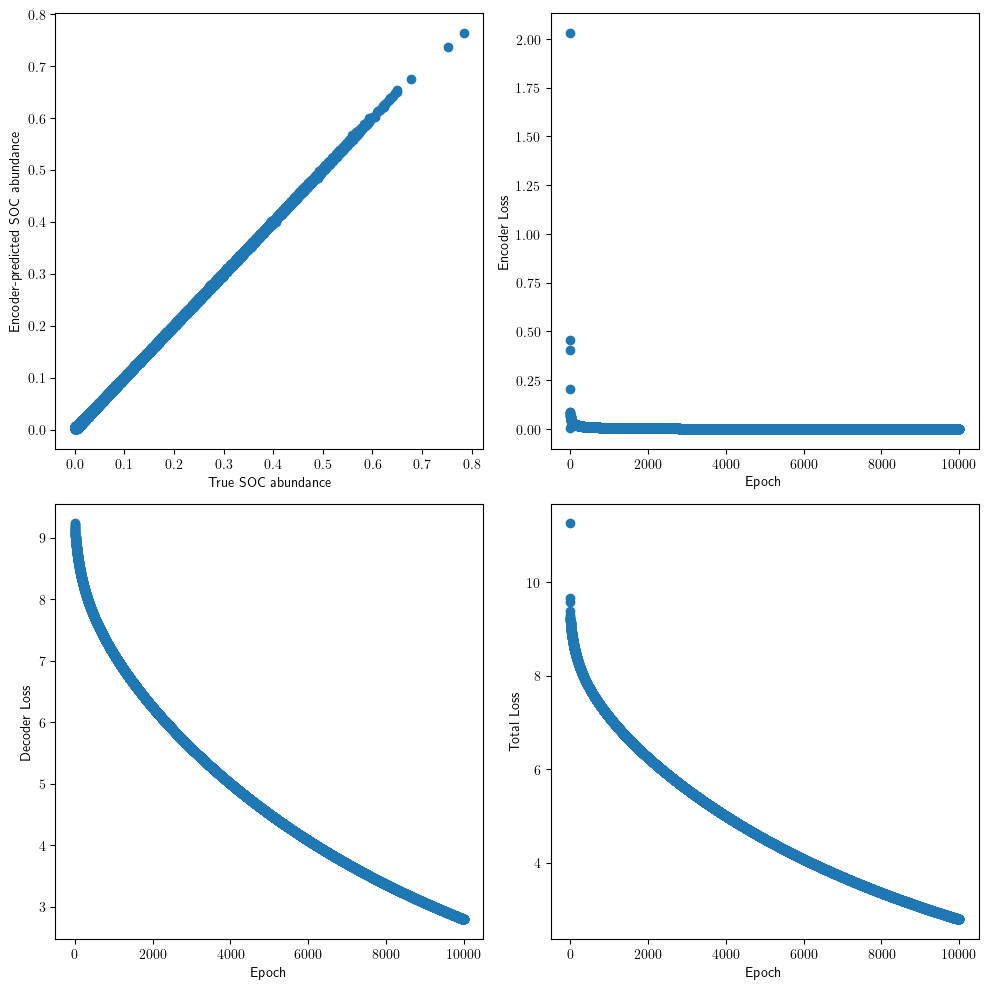

In [18]:
_, axarr = plt.subplots(2,2,figsize=(10,10))

axarr[0,0].scatter(trueMSOC[:],np.array(encoderPreds[:,-1].tolist()))
axarr[0,0].set_xlabel("True SOC abundance")
axarr[0,0].set_ylabel("Encoder-predicted SOC abundance")

axarr[0,1].scatter([i for i in range(lossTrackingEncoder.shape[0])],lossTrackingEncoder)
axarr[0,1].set_xlabel("Epoch")
axarr[0,1].set_ylabel("Encoder Loss")

axarr[1,0].scatter([i for i in range(lossTrackingDecoder.shape[0])],lossTrackingDecoder)
axarr[1,0].set_xlabel("Epoch")
axarr[1,0].set_ylabel("Decoder Loss")

axarr[1,1].scatter([i for i in range(lossTrackingEncoder.shape[0])],lossTrackingEncoder+lossTrackingDecoder)
axarr[1,1].set_xlabel("Epoch")
axarr[1,1].set_ylabel("Total Loss")

plt.tight_layout()
plt.show()

In [ ]:
import pickle

torch.save((encoderModel,decoderModel,optimizer,Is,Fs,Ms,rhorads,trueMSOC,dataInds,preds,lossTrackingEncoder,lossTrackingDecoder), "step7_fullFit_E20k_lr0p000005_b1_0p99_b2_0p999.pt")